In [105]:
# 作业1

# 导入模块及数据
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler # 过采样函数
from sklearn.linear_model import LogisticRegression # Logistic函数
from sklearn.model_selection import train_test_split # 训练集-测试集分割
from sklearn.model_selection import KFold # 交叉采样技术
from sklearn.metrics import confusion_matrix # 混淆矩阵
from sklearn.metrics import roc_curve, auc # ROC曲线，AUC值

df = pd.read_csv("Trans.csv") 
df.info()
"""
数据概览：共有748个样例，3个特征("Recency"，"Frequency"，"Time")，1个标签("Donate").
各变量均为数值型，不存在缺失值。
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    748 non-null    int64
 1   Frequency  748 non-null    int64
 2   Time       748 non-null    int64
 3   Donate     748 non-null    int64
dtypes: int64(4)
memory usage: 23.5 KB


'\n数据概览：共有748个样例，3个特征("Recency"，"Frequency"，"Time")，1个标签("Donate").\n各变量均为数值型，不存在缺失值。\n'

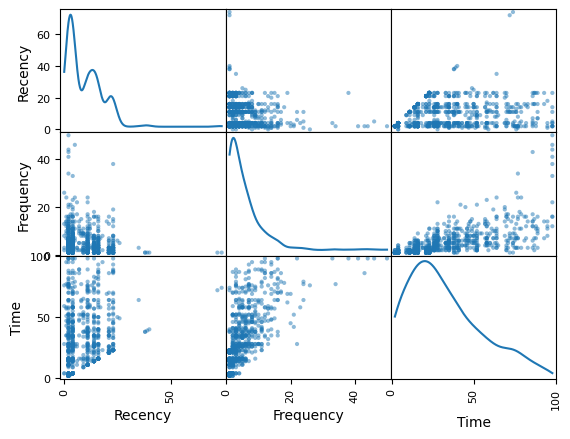

献血意愿
会:  178 
不会:  570


'\n描述性统计：\n1 特征"Recency","Frequency","Time"均呈右偏态分布，且特征之间无明显线性关系\n2 标签“Donate”数据中，献血意愿为“会”的有178个，“不会”的有570个，两者比例约1:3\n'

In [106]:
# 描述性统计
pd.plotting.scatter_matrix(df[["Recency","Frequency","Time"]], diagonal="density")
plt.show()

count_0 = 0
count_1 = 0
length = len(df["Donate"])
for i in range(length):
    if df["Donate"][i]==0:
        count_0 = count_0+1
    else:
        count_1 = count_1+1
print("献血意愿"+"\n"+"会: ",count_1,"\n"+"不会: ",count_0)

"""
描述性统计：
1 特征"Recency","Frequency","Time"均呈右偏态分布，且特征之间无明显线性关系
2 标签“Donate”数据中，献血意愿为“会”的有178个，“不会”的有570个，两者比例约1:3
"""


In [107]:
# Logistic回归参数估计

df_X = df[["Recency","Frequency","Time"]]
df_Y = df["Donate"]

# 过采样解决标签数据不平衡问题
ros=RandomOverSampler(random_state=0) 
df_X, df_Y = ros.fit_resample(df_X,df_Y)

# 构建Logistic模型
LR = LogisticRegression(penalty="none").fit(df_X, df_Y) # 标准Logistic回归，设定概率阈值为0.5(使用全部数据)
print(LR.coef_)
"""
各特征或变量在模型中参数估计为：
"Recency"： -0.07749838
"Frequency"： 0.15739225
"Time"： -0.02716467
"""

[[-0.07749838  0.15739225 -0.02716467]]


'\n各特征或变量在模型中参数估计为：\n"Recency"： -0.07749838\n"Frequency"： 0.15739225\n"Time"： -0.02716467\n'

In [108]:
# 求混淆矩阵

X_train,  X_test, Y_train, Y_test = train_test_split(df_X, df_Y, test_size=0.3, random_state=0) # 由于题目未给定测试集，故从过采样后数据集中随机抽取30%作为测试集
LR = LogisticRegression(penalty="none").fit(X_train, Y_train)
Y_pred = LR.predict(X_test)
C = confusion_matrix(Y_test, Y_pred)
print(C)
"""
测试集中共有342个样例，经计算得如下混淆矩阵：
[[114  53]
 [ 40 135]]
预测=0，实际=0：114
预测=0，实际=1：40
预测=1，实际=0：53
预测=1，实际=1：135
"""

[[114  53]
 [ 40 135]]


'\n测试集中共有342个样例，经计算得如下混淆矩阵：\n[[114  53]\n [ 40 135]]\n预测=0，实际=0：114\n预测=0，实际=1：40\n预测=1，实际=0：53\n预测=1，实际=1：135\n'

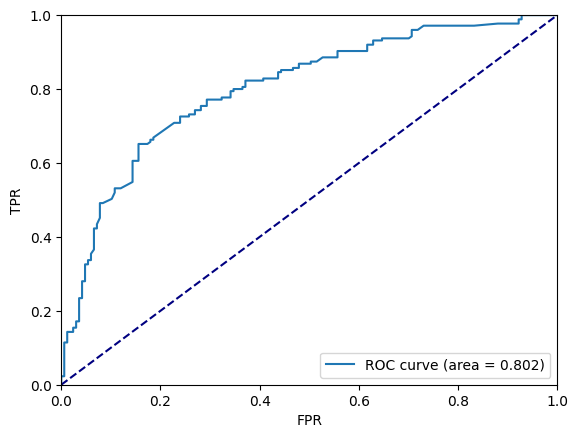

In [109]:
# 画ROC曲线

FPR, TPR, thresholds = roc_curve(Y_test, LR.decision_function(X_test))
AUC = auc(FPR, TPR)
plt.plot(FPR,TPR,label="ROC curve (area = "+str(round(AUC,3))+")")
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc="lower right")
plt.show()

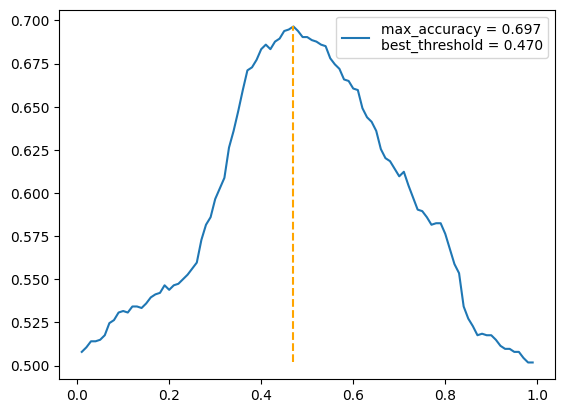

In [132]:
# 最佳概率阈值
def Acc(Y_prob, threshold, Y_test):
    length = len(Y_prob)
    count = 0 
    for i in range(length):
        if (Y_prob[i]<threshold and Y_test[i]==1) or (Y_prob[i]>=threshold and Y_test[i]==0):
            count = count+1
    return count/length


kf = KFold(n_splits = 10, random_state = 0, shuffle=True) # 十折交叉采样
Thresholds = np.arange(0.01, 1, 0.01) # 概率阈值
Accuracy = np.array([]) # 准确率（误判率 = 1 - 准确率）
length = len(Thresholds)
for j in range(length):
    acc = np.array([]) # 单次交叉验证后的十个准确率值
    for index_train, index_test in kf.split(df_X, df_Y): #
        X_train = df_X.iloc[index_train,:]; Y_train = df_Y.iloc[index_train] # 训练集之一
        X_test = df_X.iloc[index_test,:]; Y_test_temp = df_Y.iloc[index_test] # 测试集之一
        Y_test = np.array([]) # 考虑到Y_test_temp中索引号不是从0开始，故copy
        for value in Y_test_temp:
            Y_test = np.append(Y_test, value)
        LR = LogisticRegression(penalty="none").fit(X_train, Y_train)
        Y_prob = LR.predict_proba(X_test)
        Y_prob = Y_prob.T[0]
        acc = np.append(acc, Acc(Y_prob, Thresholds[j], Y_test))
    Accuracy =  np.append(Accuracy, np.average(acc))

max_index = np.argmax(Accuracy)
best_threshold = Thresholds[max_index]

plt.plot(Thresholds, Accuracy,label = "max_accuracy = 0.697"+"\n"+"best_threshold = 0.470")
plt.vlines(0.47000000000000003, ymin = np.min(Accuracy), ymax = np.max(Accuracy), linestyle='--', color = "orange")
plt.legend()
plt.show()

"""
由图可知，当判别阈值约为0.47时，误判率达到最小，为1-0.697=0.203
"""